<font size=6>This notebook is to examine 'Kapoor_adjacency.csv' and 'Kapoor_TOM.csv' files.</font>

<font size=6>Conclusions:</font></br>
## 1) Deseq has 14474 of the IDs in the network. The network has 19911 of the IDs in the expression file. 5437 genes in the network are not in the deseq file. 
## 2) The average weight in the entire adjacency network is 0.00064 amd the standard deviation of the weights in the adjacency network df is 0.00367
## 3) In the adjacency network, 370 out of 19911 x 19911 total edges had weights > 0.8.
## 4) The average weight in the TOM network is 0.0014 and the standard deviation of the weights in the TOM network is 0.0037
## 5) In the adjacency network, 490 out of 19911 x 19911 total edges had weights > 0.8.

# Table of Contents
<font size=5><a href='#load-dfs'>1. Load data</a></font></br>
<font size=5><a href='#Check-ensemble-IDs-in-each-data-file'>2. Check ensemble IDs in each file</a></font></br>
<font size=5><a href='#Use-the-method-described-in-this-stackoverflow-post-to-calculate-TOM-from-adjacency-df'>3. Check adjacency to TOM conversion</a></font></br>
<font size=5><a href='#Basic-stats-on-the-adjacency-network'>4. Baseic stats on the adjacency network</a></font></br>
<font size=5><a href='#Basic-stats-on-the-TOM-network'>5. Baseic stats on the TOM network</a></font></br>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
%matplotlib inline

# load dfs

In [2]:
adj_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_adjacency.csv', index_col = 0)
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0, chunksize = 1000) # Just compare the first couple so no need to import all

In [3]:
# getting the first subset df with 1000 rows from tom_df 
for df in tom_df:
    tom_subset = df
    break

In [4]:
expression = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\kapoor2019_batch.age.rin.sex.pm.alc.corrected.coga.inia.expression.txt', sep = '\t')
deseq = pd.read_excel(r'G:\Shared drives\NIAAA_ASSIST\Data\deseq.alc.vs.control.age.rin.batch.gender.PMI.corrected.w.prot.coding.gene.name.xlsx')

In [5]:
network_IDs = pd.Series(adj_df.columns)

In [6]:
network_IDs.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_IDs.csv')

In [7]:
# network_IDs = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\network_IDs.csv')

In [8]:
print('Number of IDs in the expression data:', len(expression))
print('Number of IDs in the network data:', len(network_IDs))
print('Number of IDs in the deseq data:', len(deseq))

Number of IDs in the expression data: 62730
Number of IDs in the network data: 19911
Number of IDs in the deseq data: 14474


# Check ensemble IDs in each data file

In [9]:
# number of IDs in the expression data but not in the network data
len(list(set(expression.id) - set(network_IDs['0'])))

42819

In [10]:
# number of IDs in the network data but not in the expression data
len(list(set(network_IDs['0'])-set(expression.id)))

0

In [11]:
# number of IDs in the deseq data but not in the network data
len(list(set(deseq.id) - set(network_IDs['0'])))

0

In [12]:
# number of IDs in the network data but not in the deseq data
len(list(set(network_IDs['0']) - set(deseq.id)))

5437

## Venn diagram to show the ID overlap from expression, network and deseq

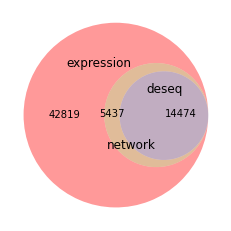

In [13]:
vd = venn3([set(expression.id), set(network_IDs['0']), set(deseq.id)], ('expression', 'network', 'deseq'))
# adjust the text locations
vd.get_label_by_id("A").set_x(0)
vd.get_label_by_id("A").set_y(0.3)
vd.get_label_by_id("B").set_x(-0.15)
vd.get_label_by_id("B").set_y(-0.2)
vd.get_label_by_id("C").set_x(0.2)
vd.get_label_by_id("C").set_y(0.2)
vd.get_label_by_id("111").set_x(0.3)
plt.show()

<font size=6>The network file has 5437 more IDs than in deseq file. Where did these extra ID come from?</font>

# Use the method described in this stackoverflow post to calculate TOM from adjacency df
<font size=5>https://stackoverflow.com/questions/56574729/how-to-compute-the-topological-overlap-measure-tom-for-a-weighted-adjacency-ma</font>

In [14]:
A = adj_df.copy()
d = len(adj_df)
A.iloc[range(d), range(d)] = 0 
L = A @ A  
K = A.sum(axis=1)

In [15]:
# Only loop the first 2 rows for simplicity
A_tom = np.zeros_like(A)
for j in range(1, d):  
    numerator = L.iloc[0, j] + A.iloc[0, j]
    denominator = min(K[0], K[j]) + 1 - A.iloc[0, j]
    A_tom[0, j] = numerator / denominator

In [16]:
for j in range(2, d):  
    numerator = L.iloc[1, j] + A.iloc[1, j]
    denominator = min(K[1], K[j]) + 1 - A.iloc[1, j]
    A_tom[1, j] = numerator / denominator
    
A_tom += A_tom.T # because the for loop only keeps going down so this step adds the df back for the symmetrical side of the data
A_tom[range(d), range(d)] = 1  # Set diagonal to 1 by default

## Plot pre-calculated TOM vs TOM calculated from adjacency df 

## Example 1: ENSG00000227232 weight with other 9 genes (left figure and right figure are identical)

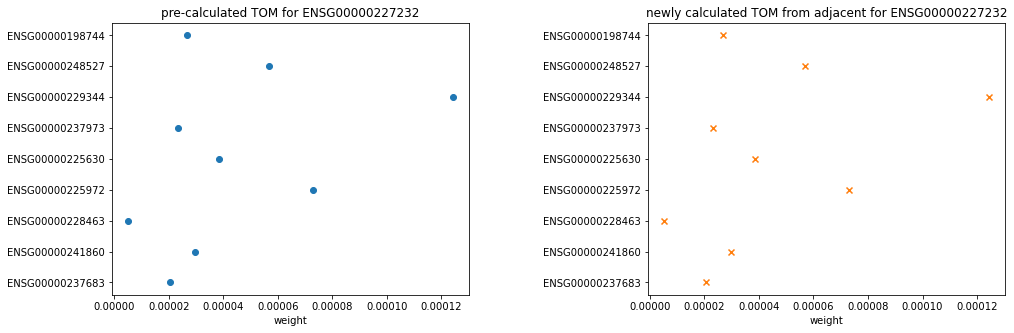

In [17]:
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.scatter(tom_subset.iloc[0,1:10], adj_df.columns[1:10], marker = 'o')
plt.title('pre-calculated TOM for ENSG00000227232')
plt.xlabel('weight')
plt.subplot(1,2,2)
plt.scatter(A_tom[0,1:10], adj_df.columns[1:10], marker = 'x', c = 'C1')
plt.title('newly calculated TOM from adjacent for ENSG00000227232')
plt.xlabel('weight')
plt.subplots_adjust(wspace =0.5)

## Overlay the above figures into 1

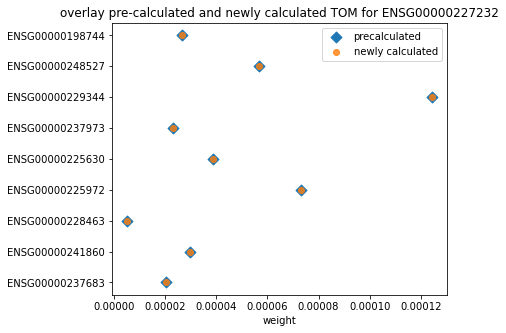

In [18]:
plt.figure(figsize = (6,5))
plt.scatter(tom_subset.iloc[0,1:10], adj_df.columns[1:10], marker = 'D', s = 60, label = 'precalculated')
plt.scatter(A_tom[0,1:10], adj_df.columns[1:10], marker = 'o', alpha = 0.8, label = 'newly calculated')
plt.title('overlay pre-calculated and newly calculated TOM for ENSG00000227232')
plt.legend()
plt.xlabel('weight');


## Example 2: ENSG00000237683 weight with other 8 genes (left figure and right figure are identical)

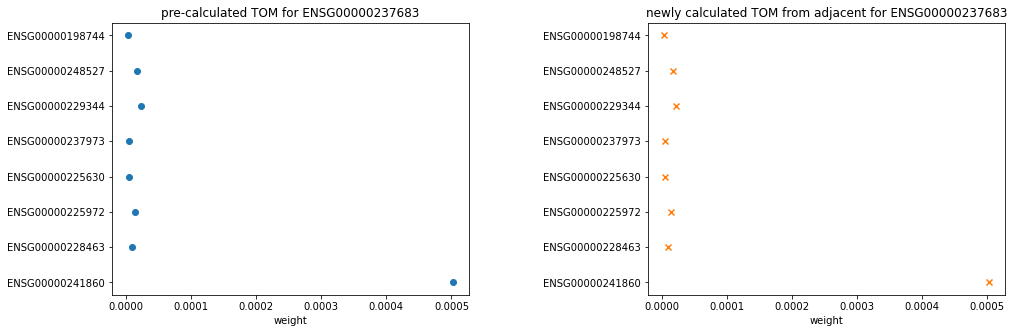

In [19]:
plt.figure(figsize = (16,5))
plt.subplot(1,2,1)
plt.scatter(tom_subset.iloc[1,2:10], adj_df.columns[2:10], marker = 'o')
plt.title('pre-calculated TOM for ENSG00000237683')
plt.xlabel('weight')
plt.subplot(1,2,2)
plt.scatter(A_tom[1,2:10], adj_df.columns[2:10], marker = 'x', c = 'C1')
plt.title('newly calculated TOM from adjacent for ENSG00000237683')
plt.xlabel('weight')
plt.subplots_adjust(wspace =0.5);

## Overlay the above figures into 1

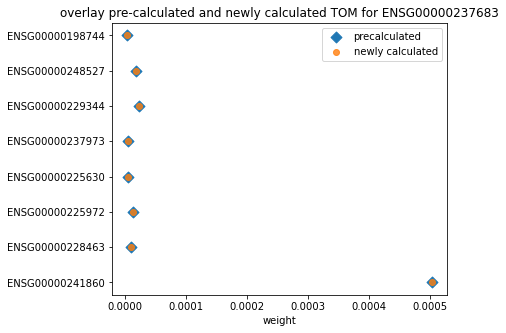

In [20]:
plt.figure(figsize = (6,5))
plt.scatter(tom_subset.iloc[1,2:10], adj_df.columns[2:10], marker = 'D', s = 60, label = 'precalculated')
plt.scatter(A_tom[1,2:10], adj_df.columns[2:10], marker = 'o', alpha = 0.8, label = 'newly calculated')
plt.title('overlay pre-calculated and newly calculated TOM for ENSG00000237683')
plt.legend()
plt.xlabel('weight');

# Basic stats on the adjacency network

In [49]:
print('The average weight in the entire network df is', np.mean(adj_df.mean()))
print('The standard deviation of the weight in the entire network df is', np.std(adj_df.std()))

The average weight in the entire network df is 0.0006404408369152931
The standard deviation of the weight in the entire network df is 0.0036700998335319943


In [51]:
print('First quantile for the weights is', np.quantile(adj_df.quantile(0.25), q= 0.25))
print('Third quantile for the weights is', np.quantile(adj_df.quantile(0.75), q= 0.75))

First quantile for the weights is 3.2716137532440656e-08
Third quantile for the weights is 5.4262695621271675e-05


## Most of the weights are on the small side (< 0.001)

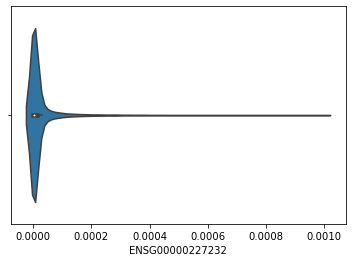

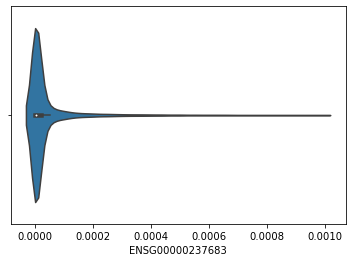

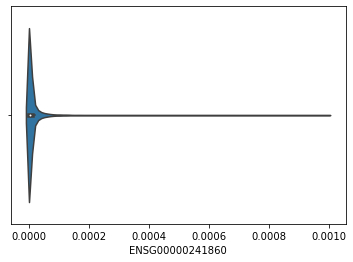

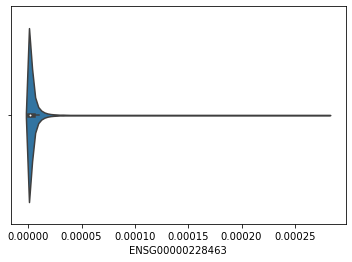

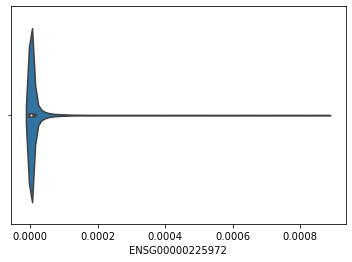

In [52]:
for col in adj_df.columns[:5]:
    sns.violinplot(x = col, data = adj_df[adj_df[col] < 0.001])
    plt.show()
    plt.close()

## Check if there are large weights for non-self gene

In [33]:
large_weight_combos = []
for col in adj_df.columns:
    within_range = adj_df[adj_df[col].between(0.8, 0.95)]
    if len(within_range) > 0:
        large_weight_combos.append(within_range[col])

In [43]:
print('Number of genes with weights > 0.8 with other genes:',len(large_weight_combos))

Number of genes with weights > 0.8 with other genes: 29


In [58]:
# count edges with weights > 0.8
sum(adj_df[adj_df > 0.8].count())

20281

In [59]:
adj_df.shape

(19911, 19911)

In [61]:
print('Number of edges with weights > 0.8 not including self is', 20281 - 19911)

Number of edges with weights > 0.8 not including self is 370


## ENSG00000198692 is an example. The gene shares weights > 0.8 with many other genes. 

In [36]:
large_weight_combos[-1]

ENSG00000129824    0.936707
ENSG00000099725    0.872143
ENSG00000233864    0.928412
ENSG00000114374    0.890534
ENSG00000228411    0.842402
ENSG00000067048    0.938830
ENSG00000183878    0.915591
ENSG00000154620    0.906806
ENSG00000241859    0.886916
ENSG00000165246    0.800302
ENSG00000226555    0.872350
ENSG00000176728    0.881530
ENSG00000131002    0.948013
ENSG00000267793    0.848159
ENSG00000260197    0.913908
ENSG00000012817    0.892999
ENSG00000229236    0.883174
Name: ENSG00000198692, dtype: float64

## Find genes that share large weights with ENSG00000198692

In [54]:
within_range_692 = adj_df[adj_df['ENSG00000198692'].between(0.8, 1)]

In [55]:
deseq[deseq.id.isin(within_range_692.index)]

,id,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
14464,ENSG00000129824,RPS4Y1,701.284754,-0.016373,0.040824,-0.401053,0.688381,0.945357
14465,ENSG00000067646,ZFY,594.374288,-0.057752,0.038205,-1.511647,0.130624,0.640777
14467,ENSG00000114374,USP9Y,4238.348172,-0.006773,0.055013,-0.123117,0.902014,0.988939
14468,ENSG00000067048,DDX3Y,2120.899133,-0.025542,0.052337,-0.488029,0.625529,0.928821
14469,ENSG00000183878,UTY,1474.654478,-0.029940,0.044795,-0.668376,0.503894,0.888744
14470,ENSG00000154620,TMSB4Y,84.936681,-0.007267,0.044268,-0.164169,0.869598,0.984755
14471,ENSG00000165246,NLGN4Y,1474.250083,0.000085,0.039417,0.002151,0.998284,0.999734
14472,ENSG00000012817,KDM5D,1944.224900,-0.072153,0.045284,-1.593317,0.111089,0.608835
14473,ENSG00000198692,EIF1AY,285.015441,0.002864,0.044471,0.064394,0.948656,0.994184


## These genes don't necessarily have similar log2FC as ENSG00000198692 but are highly connected in the network (could be that they share a lot of neighbors)

# Basic stats on the TOM network

In [65]:
# delete adj_df in the kernel first bc it's large
del adj_df

In [66]:
tom_df = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv', index_col = 0)

In [70]:
tom_df.columns = network_IDs
tom_df.index = network_IDs

In [73]:
tom_df.to_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\Kapoor_TOM.csv')

In [74]:
print('The average weight in the TOM network is', np.mean(tom_df.mean()))
print('The standard deviation of the weight in the TOM network is', np.std(tom_df.std()))

The average weight in the TOM network is 0.0014349330374716824
The standard deviation of the weight in the TOM network is 0.003691142226163624


In [75]:
print('First quantile for the weights is', np.quantile(tom_df.quantile(0.25), q= 0.25))
print('Third quantile for the weights is', np.quantile(tom_df.quantile(0.75), q= 0.75))

First quantile for the weights is 5.615638234941455e-06
Third quantile for the weights is 0.0008089684379290408


## Most of the TOM weights are on the small side (< 0.001) but larger than in adjacency weights

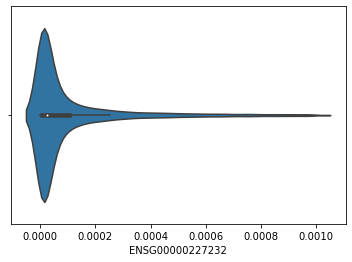

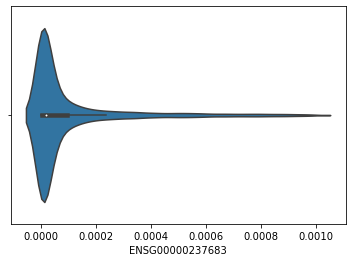

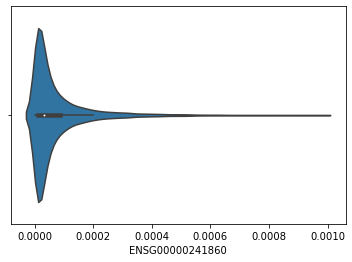

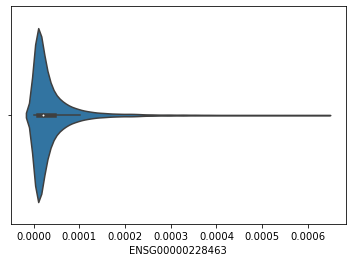

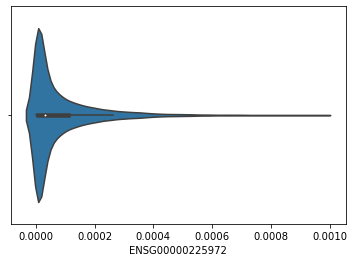

In [77]:
for col in tom_df.columns[:5]:
    sns.violinplot(x = col, data = tom_df[tom_df[col] < 0.001])
    plt.show()
    plt.close()

In [78]:
large_weight_combos = []
for col in tom_df.columns:
    within_range = tom_df[tom_df[col].between(0.8, 0.95)]
    if len(within_range) > 0:
        large_weight_combos.append(within_range[col])

In [79]:
print('Number of genes with weights > 0.8 with other genes:',len(large_weight_combos))

Number of genes with weights > 0.8 with other genes: 23


In [80]:
# count edges with weights > 0.8
sum(tom_df[tom_df > 0.8].count())

20401

In [81]:
print('Number of edges with weights > 0.8 not including self is', 20401 - 19911)

Number of edges with weights > 0.8 not including self is 490
